# Playing with lattice generation (i.e. generating non-cubic lattices)

140 0.6481481481481481


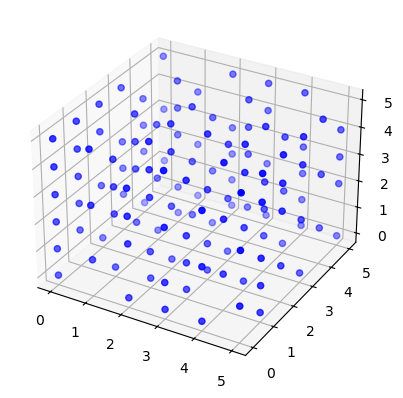

In [2]:
from math import ceil
import numpy as np
import matplotlib.pyplot as plt

from polymerist.maths.lattices import coordops
from polymerist.maths.lattices.integer import CubicIntegerLattice
from polymerist.maths.lattices.unitcell import COMMON_UNIT_LATTICE_VECTORS, LatticeParameters


max_n_atoms = 20_000
olig_size = 143

num_oligomers = ceil(max_n_atoms / olig_size)
d = ceil(num_oligomers**(1/3))

dims = np.array([d, d, d])
latt = CubicIntegerLattice(dims)
occupancy = num_oligomers / latt.capacity
stacked_points = np.vstack([latt.even_points, np.random.permutation(latt.odd_points)]) # first populate even points, and then odd points randomly into the "gaps"
oligomer_points = stacked_points[:num_oligomers]
print(num_oligomers, occupancy)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter( *oligomer_points.T, color='b')

## Generate Argon atom XYZ coordinates of reference unit vector transformed versions of an integer lattice

In [3]:
from pathlib import Path
from rdkit import Chem
from rdkit.Chem.AllChem import Compute2DCoords, EmbedMolecule
from rdkit.Geometry import Point3D


d = 4
dims = np.array([d, d, d])
latt = CubicIntegerLattice(dims)

aff = np.eye(4)
aff[:-1, -1] = 0.5
bound_points = CubicIntegerLattice(dims + 1).affine_transformation(aff)
bbox = coordops.BoundingBox(bound_points)

outdir = Path('lattices')
outdir.mkdir(exist_ok=True)
for name, lattice_vectors in COMMON_UNIT_LATTICE_VECTORS.items():
    lp = LatticeParameters.from_lattice_vectors(lattice_vectors)
    print(name, lp.lengths, lp.axial_angles(in_degrees=True), lp.volume)

    new_points = latt.points @ lattice_vectors.T
    contained_in_lattice = bbox.surrounds(new_points, strict=False)
    outside_lattice = ~contained_in_lattice

    new_points = np.mod(new_points - bbox.lower, bbox.dims)
    l_init = len(new_points)
    new_points = np.unique(new_points, axis=0)
    l_final = len(new_points)
    print(l_init - l_final)

    conf = Chem.Conformer()
    atom_smiles = []
    for i, point in enumerate(new_points):
        conf.SetAtomPosition(i, point.astype(float))
        atom_smiles.append('[Ar]')
    conf.Set3D(True)

    mol = Chem.MolFromSmiles('.'.join(atom_smiles))
    mol.AddConformer(conf)
    xyzpath = outdir / f'{name.lower()}.xyz'
    Chem.MolToXYZFile(mol, str(xyzpath))

CUBIC [1. 1. 1.] [90. 90. 90.] 1.0
0
HEXAGONAL [1. 1. 1.] [ 90.  90. 120.] 0.8660254037844384
0
RHOMBOHEDRAL [1. 1. 1.] [60. 60. 60.] 0.7071067811865471
0
RHOMBIC_DODECAHEDRON_XY_SQR [1. 1. 1.] [60. 60. 90.] 0.7071067811865474
0
TRUNCATED_OCTAHEDRON [1. 1. 1.] [ 70.52877937 109.47122063  70.52877937] 0.7698003589195008
0


## Development of Bravais-lattice-in-bouding-box calculation

In [28]:
from typing import Optional, TypeVar
from polymerist.genutils.typetools.numpytypes import Shape, N, M, DType
from polymerist.genutils.typetools.categorical import Numeric

TT = TypeVar('TT', bound=Numeric) # typevar to signify returns which are all of the same numeric type 

class Coordinates:
    '''Represention class for encapsulating M-vectors of N-dimensional coordinates, with basic coordinate operations'''
    def __init__(self, points : np.ndarray[Shape[M, N], TT]) -> None:
        assert(points.ndim == 2) # only accepts vector of coordinate
        self.points = points
        self.n_dims = points.shape[-1] # the number of dimensions of a point in the vector

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}({self.n_dims}-dimensional vector of {self.n_points} points)'

    # COORDINATE VECTOR DIMENSIONS AND EXTREMAL POINTS
    @property
    def n_points(self) -> int:
        '''The number of points currently stored in the coordinates vector'''
        return self.points.shape[0] # len(self.points)

    @property
    def dimensions(self) -> np.ndarray[Shape[N], int]:
        '''The side lengths of the bounding box along each dimension'''
        return self.points.ptp(axis=0)
    dims = sidelens = sidelengths = dimensions

    @property
    def minimum(self) -> np.ndarray[Shape[N], TT]:
        '''The bounding box vertex with the smallest coordinates in each dimension'''
        return self.points.min(axis=0)
    min = lower = smallest = minimum

    @property
    def maximum(self) -> np.ndarray[Shape[N], TT]:
        '''The bounding box vertex with the largest coordinates in each dimension'''
        return self.points.max(axis=0)
    max = upper = largest = maximum

    @property
    def extrema(self) -> np.ndarray[Shape[2, N], TT]:
        '''A 2xN array of the minimal and maximal bounding box vertices'''
        return np.vstack([self.minimum, self.maximum])

    # POINT OPERATIONS
    def __call__(self, index : int) -> np.ndarray[Shape[N], TT]:
        '''Retrieve the point at the given index'''
        return self.points[index]

    def _point_is_compat(self, point : np.ndarray[Shape[N], TT]) -> bool:
        '''Internal method to check whether an incoming point is compatible with the dimensions of the current array'''
        return (
            isinstance(point, np.ndarray)
            and (point.ndim == 1)
            and (point.size == self.n_dims)
            # TODO: check compatible types? (may be too inflexible, categorical.Numeric currently doesn't recognize numpy-specific types)
        )
    
    def validate_point(self, point : np.ndarray[Shape[N], TT]) -> None:
        '''Check if a point is compatible with the coordinates, or else raise Exception with reason why not'''
        if not self._point_is_valid(point):
            raise ValueError(f'Incompatible point {point}')

    @property
    def dists_to_point(self, point : np.ndarray[Shape[N], TT], norm_order : Optional[int]=None) -> np.ndarray[Shape[M], TT]:
        '''The distance between each point in a coordinate array and a single arbitrary point'''
        assert(self._point_is_compat(point))
        return np.linalg.norm(self.points - point, ord=norm_order, axis=1)

    # MEASURES OF CENTRALITY
    def weighted_centroid(self, weights : Optional[np.ndarray[Shape[M], DType]]=None) -> np.ndarray[Shape[N], TT]:
        '''The average (center-of-mass) coordinate of a vector of coordinates, with optional array of weights for each coordinates'''
        if weights is None:
            weights = np.ones(self.n_points, dtype=self.points.dtype)
        
        # prechecks to ensure the weights vector is of compatible size
        assert(weights.ndim == 1)
        assert(weights.size == self.points.shape[0])
        weights = weights.reshape((self.points.shape[0], 1))
        
        return (self.points * weights).mean(axis=0)

    @property
    def centroid(self) -> np.ndarray[Shape[N], TT]:
        '''The unweighted average coordinate of the vector'''
        return self.weighted_centroid() # weighed centroid with default unit weights
    center_of_mass = COM = centroid

    @property
    def dists_to_centroid(self, norm_order : Optional[int]=None, weights : Optional[np.ndarray[Shape[M], DType]]=None) -> np.ndarray[Shape[M], DType]:
        '''The distance of each coordinate in an array of coordinates to the coordinates' centroid'''
        return self.dists_to_point(point=self.weighted_centroid(weights=weights), norm_order=norm_order)
    effective_radii = eff_rad = dists_to_centroid

    # LATTICE TRANSFORMATIONS
    def translate(self, displacement : np.ndarray[Shape[N], TT]) -> None:
        '''Apply affine shift (translation only) to all points'''
        self.validate_point(displacement)
        self.points += displacement # TODO: use explicit broadcast here to reduce ambiguity?

    def linear_transformation(self, matrix : np.ndarray[Shape[N,N], float], periodic : bool=False) -> np.ndarray[Shape[M, N], float]:
        '''Accepts an NxN matrix (where N is the dimension of the lattice), returns a linearly-transformed copy of the coordinate points'''
        assert(matrix.shape == (self.n_dims, self.n_dims))
        return self.points @ matrix.T # NOTE: need to right-multiply and transpose, since ROWS of self.points need to be tranformed 

    def affine_transformation(self, matrix : np.ndarray[Shape[N,N], float], periodic : bool=False) -> np.ndarray[Shape[M, N], float]: # TOSELF: typehint on input matrix should be of shape N+1, N+1
        '''Accepts an NxN matrix (where N is the dimension of the lattice), returns an affinely-transformed copy of the coordinate points'''
        assert(matrix.shape == (self.n_dims + 1, self.n_dims + 1))
        aug_points = np.concatenate([self.points, np.ones((self.n_points, 1), dtype=int)], axis=1) # augment points vectors with extra columns of ones
        aug_transformed = aug_points @ matrix.T

        return aug_transformed[: , :self.n_dims] / aug_transformed[:, self.n_dims, None] # downcast augmented transformed points from homogeneous coordinates, normalizing by projective part

In [5]:
from typing import TypeVar

from polymerist.genutils.typetools.numpytypes import Shape, N, M
from polymerist.genutils.typetools.categorical import Numeric
T = TypeVar('T', bound=Numeric)


def identify_bravais_points_within_bbox(lattice_vectors : np.ndarray[Shape[N, N], T], bbox : coordops.BoundingBox) -> tuple[np.ndarray[Shape[M, N], T], CubicIntegerLattice]:
    '''Locate all lattice points generated by a set of Bravais lattice vectors in N-dimensions which fall within a given bounding box
    Returns the coordinate vector of the internal lattice points and a CubicIntegerLattice containing the corresponding lattice vector multiplicities'''
    # 1) transform the bounding box into the inverse domain, where Bravais lattice points "look like" integer points
    inv_bbox_vertices = bbox.vertices @ np.linalg.inv(lattice_vectors.T)
    inv_bbox_center = coordops.COM(inv_bbox_vertices)
    directors = (inv_bbox_vertices - inv_bbox_center) # directional vectors at each vertex which are away from transformed box center
    directors /= np.linalg.norm(directors, axis=1)[:, None] # normalize direction vectors

    # 2) find the nearest integer-valued points to transformed bounding box points in directions "away" from the bounding box
    integral_bounding_points = np.vstack([ 
        coordops.nearest_int_coord_along_normal(point, director) # ...(ensures no bounded points end up outside of final box)
            for point, director in zip(inv_bbox_vertices, directors)
    ])

    # 3) produce collection of integer point which contains AT LEAST the integral points bounded by the transformed nearest-integrer bounding points
    trial_bbox = coordops.BoundingBox(integral_bounding_points)  # TODO: box is pretty inefficient for highly-sheared unit vectors: need simple method to test for integral points within a bounding volume (or simplex) 
    trial_int_latt = CubicIntegerLattice(trial_bbox.dims + 1) # need K+1 unit-spaced points to space an interval K units long (e.g. [0-2] -> (0, 1, 2))
    trial_int_latt.points += trial_bbox.minimum # offset lattice from default at origin

    # 4) transforms the trial points back to the normal domain and performa final enclosure check
    trial_latt_points = trial_int_latt.linear_transformation(lattice_vectors)
    is_inside = bbox.surrounds(trial_latt_points).all(axis=1) # mask of which points have ALL coordinates inside the bounding box
    inside_latt_points    = trial_latt_points[is_inside]
    trial_int_latt.points = trial_int_latt.points[is_inside]  # screen out integral points which fall outside the bounding box when mapped to lattice points
    
    return inside_latt_points, trial_int_latt

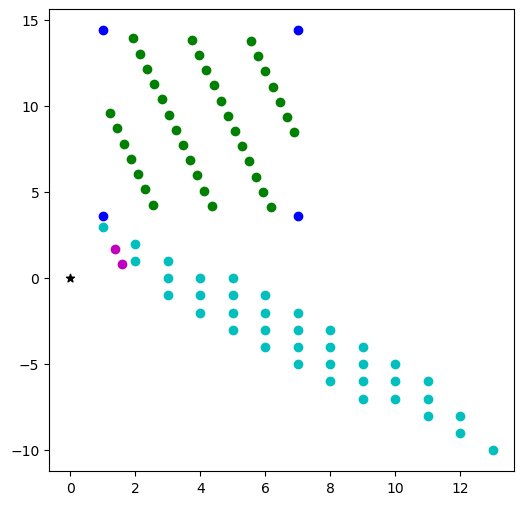

In [22]:
A = np.random.random((2,2)) * 2
# A = np.array([[1.70662421, 0.2153812 ],
#        [0.8585849 , 0.69584722]])

bbox_extrema = np.array([
    [ 1.0, 3.6],
    [ 7.0, 14.4],
])
bbox = coordops.BoundingBox(bbox_extrema)
inner_points, int_latt = identify_bravais_points_within_bbox(A, bbox)

s = 6
fig = plt.figure(figsize=(s, s))
ax  = fig.add_subplot()
ax.scatter([0], [0], color='k', marker='*')
ax.scatter(*A              , color='m')
ax.scatter(*bbox.vertices.T, color='b')
ax.scatter(*int_latt.points.T     , color='c')
ax.scatter(*inner_points.T , color='g')

In [ ]:
from polymerist.genutils.typetools.numpytypes import Shape, N, M

def _identify_trial_integer_points(bbox : coordops.BoundingBox, lattice_vectors : Shape[N, N]) -> np.ndarray[int]:
    '''Identify a trial set of integer points in N-dimensions which contain all corresponding lattice points within a bounding box'''
    

    scale = 3
    dims = np.array([5, 5])
    latt = CubicIntegerLattice(dims)


    latt_COM     = coordops.COM(latt.points)
    bbox = np.vstack(coordops.bounding_box_extrema(latt.points))

    inv = coordops.bounding_box_points(latt.points) @ np.linalg.inv(A.T)
    inv_COM = coordops.COM(inv)
    int_bounds = np.vstack([
        coordops.nearest_int_coord_along_normal(pnt, pnt - inv_COM)
            for pnt in inv
    ])
    directors = (inv - inv_COM)

    lower2, upper2 = coordops.bounding_box_extrema(int_bounds)
    trial_lattice = CubicIntegerLattice(coordops.bounding_box_dims(int_bounds)+1).points + lower2 # TODO: this search lattice could be made much tighter given an efficent method for enumerating integer points within a bounded polytope 
    shear = trial_lattice @ A.T

    in_box = coordops.coords_inside_bbox(shear, *bbox).all(axis=1)
    within = shear[in_box]
    minset = within @ np.linalg.inv(A.T)
    minset = minset.astype(int)

In [ ]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.spatial import Delaunay, delaunay_plot_2d

hull = ConvexHull(int_bounds)
ax1  = fig.add_subplot(1,2,2)

convex_hull_plot_2d(hull)
plt.show()

In [ ]:
latt = CubicIntegerLattice(np.array([2,2,2]))

delaun  = Delaunay(latt.points)
# delaunay_plot_2d(delaun)
# plt.show()

In [ ]:
delaun.points

In [ ]:
delaun.points[delaun.simplices[0]]

# Playing with cubic/octahedral symmetry groups

In [ ]:
import numpy as np
from polymerist.graphics.plotutils import scatter_3D
from polymerist.maths.lattices import generate_int_lattice

d : int = 4

# produce integer lattice
dims = np.array([d, d, d])
num_points = dims.prod()
lattice = generate_int_lattice(*dims)

# sort lexicographically
order = np.lexsort(lattice.T)
lattice = lattice[order]

# determine even and odd positions after sorting
index_is_odd = lattice.sum(axis=1) % 2
index_is_odd = index_is_odd.astype(bool)

# center lattice at the origin
COM = lattice.mean(axis=0)
lattice = lattice - COM # sort lexicographically and translate center of grid to origin

# print(order, lattice[order])

In [ ]:
import matplotlib.pyplot as plt

alternate : bool = not False
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

if alternate:
    ax.scatter(*lattice[ index_is_odd].T, color='r')
    ax.scatter(*lattice[~index_is_odd].T, color='b')
else:
    ax.scatter(*lattice.T, color='r')

labels = np.lexsort(lattice.T)
for i, coords in zip(labels, lattice):
    ax.text(*coords, str(i))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [ ]:
from typing import Generator, Iterable
from itertools import permutations, product as cartesian_product
from polymerist.maths.combinatorics.permutations import Permutation, Cycle
from scipy.spatial.transform import Rotation, Slerp


def sign_alternations(n : int) -> Generator[tuple[int, int, int], None, None]:
    '''Generate every possible n-tuple containing either 1 or -1'''
    for signs in cartesian_product(*([1, -1] for _ in range(n))):
        yield signs

def orthogonal_basis_transforms(n : int=3) -> Generator[np.ndarray, None, None]:
    '''Generate all matrices in n-dimensions which permute or invert the standard basis vectors'''
    for signs in sign_alternations(n):
        matr = np.diag(signs)
        for perm in Permutation.symmetric_group(n):
            yield matr @ perm.matrix

def interpolate_linear_transformation(trans : np.ndarray, n_frames : int=10) -> np.ndarray:
    '''Accepts a linear transformation matrix (of size MxN) and a number of frames F
    Returns an FxMxN array containing uniforms "steps" between the identity and the desired transformation'''
    I = Rotation.identity()
    rot = Rotation.from_matrix(trans)
    full_rot = Rotation.concatenate([I, rot])
    interpolator = Slerp(np.linspace(0, 1, num=len(full_rot), dtype=int), full_rot)

    return interpolator(np.linspace(0, 1, num=n_frames)).as_matrix()

In [ ]:
from collections import defaultdict

perms  = {}
all_cycles = {}

orbits = defaultdict(set)
stabilizers = defaultdict(list)

init_order = np.lexsort(lattice.T)
group_matrices = [el for el in orthogonal_basis_transforms(3)]
for i, trans in enumerate(group_matrices):
    new = lattice @ trans
    perms[i]      = perm   = Permutation(*np.lexsort(new.T))
    all_cycles[i] = cycles = perm.to_cycles(canonicalize=False)
    
    for cycle in cycles:
        if len(cycle) == 1:
            point_idx = cycle[0] # get the one element in the singleton cycle
            stabilizers[point_idx].append(trans)

        for point_idx in cycle:
            orbits[point_idx].update(cycle)

unique_orbits = set(tuple(sorted(orbit)) for orbit in orbits.values())
sum(len(i) for i in unique_orbits) == num_points

In [ ]:
stab_sizes = {k : len(v) for k, v in stabilizers.items()}
for i in unique_orbits:
    print([stab_sizes[j] for j in i])

## Visualize all symmetry actions as GIFs

In [ ]:
from pathlib import Path
from math import ceil
from matplotlib.animation import FuncAnimation, ArtistAnimation, writers
from rich.progress import track


n_frames = 20

dir = Path('gif_frames')
dir.mkdir(exist_ok=True)

ax_max = ceil(d / 2)
ax_min = -ax_max

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.autoscale(False)

def update(frame_no : int):
    partial_rot = keyframes[frame_no, :, :]
    latt_pos = lattice @ partial_rot

    ax.clear()
    ax.set(xlim3d=(ax_min, ax_max), xlabel='X')
    ax.set(ylim3d=(ax_min, ax_max), ylabel='Y')
    ax.set(zlim3d=(ax_min, ax_max), zlabel='Z')

    return ax.scatter(*latt_pos.T)

for i, trans in track(enumerate(group_matrices), total=len(group_matrices), description='Visualizing symmetry group actions...'):
    keyframes = interpolate_linear_transformation(trans, n_frames=n_frames)
    ani = FuncAnimation(fig=fig, func=update, frames=len(keyframes), interval=10)
    ani.save(dir/f'symmetry_{i+1}.gif', writer='pillow')
    plt.close(fig)

# Playing with rich progress

In [ ]:
from rich.progress import track, Progress
from time import sleep

with Progress() as progress:

    task1 = progress.add_task("[red]Downloading...", total=1000)
    task2 = progress.add_task("[green]Processing...", total=1000)
    task3 = progress.add_task("[cyan]Cooking...", total=1000)

    while not progress.finished:
        progress.update(task1, advance=0.5)
        progress.update(task2, advance=0.3)
        progress.update(task3, advance=0.9)
        sleep(0.02)

In [ ]:
import time
import random
from rich.progress import (
    BarColumn,
    Progress,
    SpinnerColumn,
    TaskProgressColumn,
    TimeElapsedColumn,
    TimeRemainingColumn,
)

def process(chunks):
    for chunk in chunks:
        time.sleep(0.1)
        yield chunk

chunks = [random.randint(1,20) for _ in range(100)]

progress_columns = (
    SpinnerColumn(),
    "[progress.description]{task.description}",
    BarColumn(),
    TaskProgressColumn(),
    "Elapsed:",
    TimeElapsedColumn(),
    "Remaining:",
    TimeRemainingColumn(),
)

with Progress(*progress_columns) as progress_bar:
    task = progress_bar.add_task("[blue]Downloading...", total=sum(chunks))
    for chunk in process(chunks):
        progress_bar.update(task, advance=chunk)

In [ ]:
import random
import time

from rich.live import Live
from rich.table import Table


def generate_table() -> Table:
    """Make a new table."""
    table = Table()
    table.add_column("ID")
    table.add_column("Value")
    table.add_column("Status")

    for row in range(random.randint(2, 6)):
        value = random.random() * 100
        table.add_row(
            f"{row}", f"{value:3.2f}", "[red]ERROR" if value < 50 else "[green]SUCCESS"
        )
    return table


with Live(generate_table(), refresh_per_second=4) as live:
    for _ in range(40):
        time.sleep(0.4)
        live.update(generate_table())

In [ ]:
from dataclasses import dataclass
from rich.console import Console, ConsoleOptions, RenderResult
from rich.table import Table

@dataclass
class Student:
    id: int
    name: str
    age: int
    def __rich_console__(self, console: Console, options: ConsoleOptions) -> RenderResult:
        yield f"[b]Student:[/b] #{self.id}"
        my_table = Table("Attribute", "Value")
        my_table.add_row("name", self.name)
        my_table.add_row("age", str(self.age))
        yield my_table